In [ ]:
import glob
import xarray as xr
import numpy as np
import cmocean
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import path, colors
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import skimage.io as io
from scipy import stats
import pandas as pd
from datetime import datetime, timedelta
from scipy.ndimage import generic_filter
import numba as nb

In [2]:
%load_ext autoreload
%autoreload 2

import beachings

In [313]:
import matplotlib as mpl
from matplotlib import rc

font = {'family' : 'Latin Modern Math', #['serif', 'sans-serif', 'cursive', 'fantasy', 'monospace']
        'style'  : 'normal', #['normal', 'italic', 'oblique']
        'weight' : 'normal', #['light', 'normal', 'medium', 'semibold', 'bold', 'heavy', 'black']
        'size'   : 8}

mpl.rc('font', **font)


plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["xtick.major.size"] = 2.5
plt.rcParams["ytick.major.size"] = 2.5
plt.rcParams["xtick.major.pad"] = 1
plt.rcParams["ytick.major.pad"] = 1
plt.rcParams["xtick.labelsize"] = 6
plt.rcParams["ytick.labelsize"] = 6

In [ ]:
criteria = 'c1'

f = open(f'beachings_{criteria}.csv', 'w')
f.write("release, land, cid0, lon0, lat0, mass0, days, cid1, lon1, lat1, mass1\n")
f.close()

for year in range(2010, 2022):
    for month in range(1,13):
        file = f'../data/output/cm_mpw/cm_mpw_{year}-{month:02d}-01.nc'

        ds = xr.open_dataset(file)
        lon = ds.lon.values
        lat = ds.lat.values
        nb_traj, nb_obs = lon.shape
        origin_date = datetime(2010,1,1)

        ds_origin = pd.read_csv(f'releases/particles_info_{year}{month:02d}01.csv', parse_dates=['date'])

        # distance
        d = beachings.haversine(lon, lat)

        # identify beaching
        b_idx = np.zeros(nb_traj, dtype=int)

        if criteria == 'c1':
            # a drifters is considered beach if it travels less 100km in the past 30 days
            threshold_distance = 100*1000 # [m]
            period = 30  # [days]

            for i in range(0, nb_traj):
                b_idx[i] = beachings.identify_beaching_c1(d[i], threshold_distance, period)
        elif criteria == 'c2':
            # a drifters is considered beach if it travels less than 3km for 30 days in a row
            threshold_distance = 3000 # [m]
            period = 30  # [days]

            for i in range(0, nb_traj):
                b_idx[i] = beachings.identify_beaching_c2(d[i], threshold_distance, period)
        else:
            print('Criteria not defined.')
            b_idx = None

        beached = b_idx != -99999

        land = np.hstack((np.ones(11315, dtype='bool'), np.zeros(len(lon)-11315, dtype='bool')))[beached]
        lon0 = ds_origin.loc[beached]['longitude'].values
        lat0 = ds_origin.loc[beached]['latitude'].values
        lon1 = lon[beached, b_idx[beached]]
        lat1 = lat[beached, b_idx[beached]]

        b_release = ds_origin.loc[beached]['date'].dt.strftime('%Y-%m-%d').values
        b_time = b_idx[beached]  # days 

        m0 = ds_origin.loc[beached]['weight [ton]'].values
        m1 = beachings.decay(m0, b_time/365)

        cid_0 = ds_origin.loc[beached]['country id'].values
        cid_1 = beachings.global_country_id(lon1, lat1)

        # append to csv
        fid = open(f'beachings_{criteria}.csv', 'a')
        np.savetxt(fid, np.column_stack((b_release.astype(object), land, cid_0, lon0, lat0, m0, b_time, cid_1, lon1, lat1,  m1)), 
                   fmt='%s, %d, %d, %.10f, %.10f, %.3f, %d, %d, %.10f, %.10f, %.3f',
                   delimiter=', ', newline ='\n')
        fid.close()

In [83]:
criteria = 'c2'

f = open(f'beachings_{criteria}.csv', 'w')
f.write("release, land, cid0, lon0, lat0, mass0, days, cid1, lon1, lat1, mass1\n")
f.close()

for year in range(2010, 2022):
    for month in range(1,13):
        file = f'../data/output/cm_mpw/cm_mpw_{year}-{month:02d}-01.nc'

        ds = xr.open_dataset(file)
        lon = ds.lon.values
        lat = ds.lat.values
        nb_traj, nb_obs = lon.shape
        origin_date = datetime(2010,1,1)

        ds_origin = pd.read_csv(f'releases/particles_info_{year}{month:02d}01.csv', parse_dates=['date'])

        # distance
        d = beachings.haversine(lon, lat)

        # identify beaching
        b_idx = np.zeros(nb_traj, dtype=int)

        if criteria == 'c1':
            # a drifters is considered beach if it travels less 100km in the past 30 days
            threshold_distance = 100*1000 # [m]
            period = 30  # [days]

            for i in range(0, nb_traj):
                b_idx[i] = beachings.identify_beaching_c1(d[i], threshold_distance, period)
        elif criteria == 'c2':
            # a drifters is considered beach if it travels less than 3km for 30 days in a row
            threshold_distance = 3000 # [m]
            period = 30  # [days]

            for i in range(0, nb_traj):
                b_idx[i] = beachings.identify_beaching_c2(d[i], threshold_distance, period)
        else:
            print('Criteria not defined.')
            b_idx = None

        beached = b_idx != -99999

        land = np.hstack((np.ones(11315, dtype='bool'), np.zeros(len(lon)-11315, dtype='bool')))[beached]
        lon0 = ds_origin.loc[beached]['longitude'].values
        lat0 = ds_origin.loc[beached]['latitude'].values
        lon1 = lon[beached, b_idx[beached]]
        lat1 = lat[beached, b_idx[beached]]

        b_release = ds_origin.loc[beached]['date'].dt.strftime('%Y-%m-%d').values
        b_time = b_idx[beached]  # days 

        m0 = ds_origin.loc[beached]['weight [ton]'].values
        m1 = beachings.decay(m0, b_time/365)

        cid_0 = ds_origin.loc[beached]['country id'].values
        cid_1 = beachings.global_country_id(lon1, lat1)

        # append to csv
        fid = open(f'beachings_{criteria}.csv', 'a')
        np.savetxt(fid, np.column_stack((b_release.astype(object), land, cid_0, lon0, lat0, m0, b_time, cid_1, lon1, lat1,  m1)), 
                   fmt='%s, %d, %d, %.10f, %.10f, %.3f, %d, %d, %.10f, %.10f, %.3f',
                   delimiter=', ', newline ='\n')
        fid.close()

In [912]:
def season(date, na = True):
    """
    North Hemisphere (na): season = spring, summer, fall, winter [0,1,2,3]
    South Hemisphere: season = fall, winter, spring, summer [2,3,0,1]
    """
    month, day = date.month, date.day
    
    if (2, 21) <= (month, day) < (5, 20):
        return 0 if na else 2
    elif (5, 20) <= (month, day) < (8, 21):
        return 1 if na else 3
    elif (8, 21) <= (month, day) < (11, 21):
        return 2 if na else 0
    else:
        return 3 if na else 1

In [1106]:
display(ds)

,release,land,cid0,lon0,lat0,mass0,days,cid1,lon1,lat1,mass1,beached,season
0,2010-01-01,1,208,-53.850037,5.812482,0.483,30,208,-54.073784,5.786664,0.475,2010-01-31,3
1,2010-01-01,1,208,-53.803942,5.812480,0.483,30,208,-54.058041,5.766476,0.475,2010-01-31,3
2,2010-01-01,1,208,-53.821440,5.804647,0.483,30,208,-54.010437,5.734316,0.475,2010-01-31,3
3,2010-01-01,1,208,-53.832107,5.869294,0.483,30,208,-54.110260,5.825024,0.475,2010-01-31,3
4,2010-01-01,1,208,-56.231911,6.026595,0.362,30,208,-56.776016,5.944695,0.356,2010-01-31,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1593321,2021-11-07,0,239,-80.686917,30.138498,1.712,47,235,-81.218056,29.554104,1.668,2021-12-24,3
1593322,2021-11-07,0,239,-80.742740,30.182507,1.712,48,235,-81.199715,29.566013,1.667,2021-12-25,3
1593323,2021-11-25,0,33,-51.568269,4.475716,0.181,54,208,-51.839062,4.582016,0.176,2022-01-18,3
1593324,2021-11-25,0,33,-51.605604,4.469650,0.181,54,208,-51.840370,4.564075,0.176,2022-01-18,3


In [883]:
# plot
ds = pd.read_csv('beachings_c1.csv', delimiter=', ', parse_dates=['release'])
ds['beached'] = [ds.release[i] + timedelta(days=int(ds.days.values[i])) for i in range(0, len(ds))]
ds['season'] = [season(d) for d in ds.beached]

/tmp/ipykernel_3285800/3437246374.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ds = pd.read_csv('beachings_c1.csv', delimiter=', ', parse_dates=['release'])


In [800]:
ds_l = xr.open_dataset('../data/process/land_GLBv0.08.nc')
land = ds_l.land.values
plon = ds_l.plon.values # center of cell
plat = ds_l.plat.values
qlon = ds_l.qlon.values # corner of cell
qlat = ds_l.qlat.values 
ds_l.close()

# subsample
grid_f = 2
qlon = qlon[::grid_f] # 3
qlat = qlat[::grid_f]
plon = np.convolve(qlon, [0.5, 0.5], mode='valid')
plat = np.convolve(qlat, [0.5, 0.5], mode='valid')

### summed into qlon,qlat boxes

In [801]:
ret_c = stats.binned_statistic_2d(ds['lon1'].values, ds['lat1'].values, 
                                  ds['mass1'].values, 
                                  statistic='sum', 
                                  bins=[qlon, qlat])
beached_mass = ret_c.statistic.T

### summed into closest coastal box

In [802]:
@nb.njit
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.
    """
    lon1, lat1 = np.radians(lon1), np.radians(lat1)
    lon2, lat2 = np.radians(lon2), np.radians(lat2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    # distance
    earthRadius = 6371 # km
    d = 2 * np.arcsin(np.sqrt(a)) * earthRadius # km
    return d

In [803]:
# this is ugly and I'm sure there is a function for this
# but I could not find quickly and got annoyed
land_sub = np.zeros((len(plat), len(plon)), dtype='bool')
for i in range(0, len(plat)):
    for j in range(0, len(plon)):
        ri = slice(i*grid_f, (i+1)*grid_f)
        rj = slice(j*grid_f, (j+1)*grid_f)
        land_sub[i,j] = True if np.mean(land[ri,rj]) > 0 and np.mean(land[ri,rj]) < 1 else False

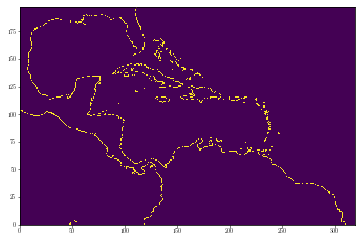

In [804]:
plt.pcolormesh(land_sub)

In [805]:
gplon, gplat = np.meshgrid(plon, plat)
gi, gj = np.where(land_sub)
land_lon, land_lat = gplon[land_sub], gplat[land_sub]

In [926]:
coastal_beached_mass = np.zeros_like(land_sub, dtype='float')

for i in range(0, len(ds['lon1'])):
    d = haversine(ds['lon1'][i], ds['lat1'][i], land_lon, land_lat)
    k = np.argmin(d) # closest land box
    coastal_beached_mass[gi[k],gj[k]] += ds['mass1'][i] # (i,j) -> (gi[k], gj[k])

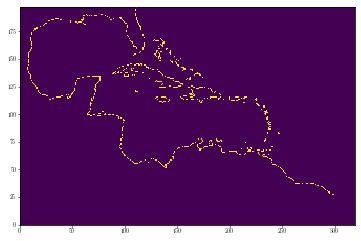

In [807]:
plt.pcolormesh(coastal_beached_mass>0)

In [808]:
np.max(beached_mass)

102457.13100003349

In [1103]:
def radius(mass):
    categories = np.array([0, 10, 100, 1000, 10000, 100000])
    size = np.array([0.3, 0.4, 0.5, 0.75, 1.5, 5])/5
    arg = np.array([np.argmin(np.abs(m-categories)) for m in mass])
    return arg+0.5, size[arg]

In [1100]:
nnz = np.where(beached_mass)
colors, scaled_mass = radius(beached_mass[nnz])

In [1101]:
np.sum(colors == 0.5)

1226

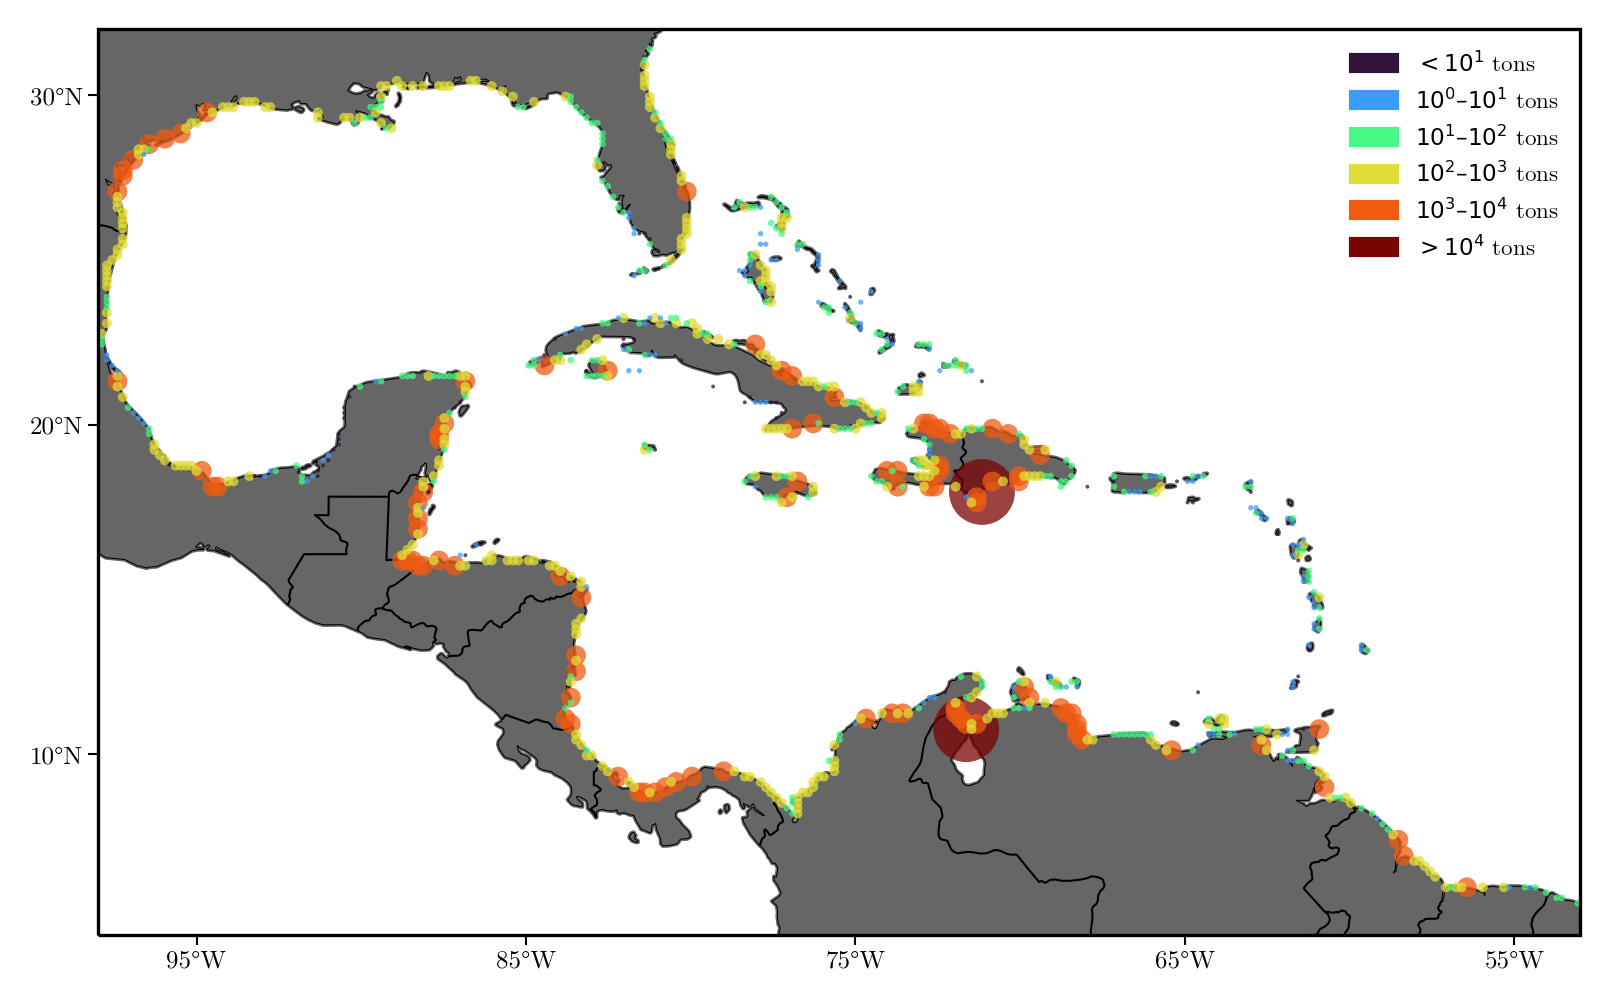

In [1104]:
fig = plt.figure(dpi=300, figsize=(8,4))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(), aspect='equal')

ax.add_feature(cfeature.LAND, facecolor='0.4', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, zorder=1)
    
#a = ax.scatter(plon[nnz[1]], plat[nnz[0]], 
#           s=np.exp(beached_mass[nnz]/(0.20*np.nanmax(beached_mass))), 
#          c=beached_mass[nnz], lw=2, marker='o',
#          )

#nnz = np.where(beached_mass)
#colors, scaled_mass = radius(beached_mass[nnz])
nnz = np.where(coastal_beached_mass)
colors, scaled_mass = radius(coastal_beached_mass[nnz])

patches = []
for x1, y1, r in sorted(zip(plon[nnz[1]], plat[nnz[0]], scaled_mass), key = lambda x: x[2], reverse=True):
    circle = Circle((x1, y1), r)
    #circle = Wedge((x1, y1), r, 0, 360, width=0.1)
    patches.append(circle)

cmap = plt.cm.turbo
     
p = PatchCollection(patches, alpha=0.75, cmap=cmap_name)
p.set_array(sorted(colors, reverse=True))
p.set_clim([np.min(colors), np.max(colors)])
ax.add_collection(p)

ax.set_xlim([-98, -53])
ax.set_ylim([4.5, 32])
ax.set_xticks([-95, -85,-75,-65,-55], crs=ccrs.PlateCarree())
ax.set_yticks([10,20,30], crs=ccrs.PlateCarree())

#ax.set_xlim([-86, -85])
#ax.set_ylim([29, 31])

ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
#ax.set_title(f"{caribbean_countries[c_id]} {(origin_date+timedelta(days=t0)).strftime('(%Y-%m-%d)')}")

#fig.colorbar(p)

handles = []
handles.append(Polygon([(0,0),(5,0)], color=cmap(p.norm(np.min(colors))), label=f'$<10^{1}$ tons'))
for i,c in enumerate(np.unique(colors)[1:-1]):
    handles.append(Polygon([(0,0),(10,0),(0,-10)], color=cmap(p.norm(c)), label=f'$10^{i}–10^{i+1}$ tons'))
handles.append(Polygon([(0,0),(10,0),(0,-10)], color=cmap(p.norm(np.max(colors))), label=f'$>10^{i+1}$ tons'))
ax.legend(handles=handles, frameon=False, fontsize='x-small')  

fig.savefig(f'hotspot_c1.png', bbox_inches='tight', format='png', dpi=600)

# seasonality

In [923]:
coastal_beached_mass_seasons = np.zeros((4, land_sub.shape[0], land_sub.shape[1]), dtype='float')

for i in range(0, len(ds['lon1'])):
    d = haversine(ds['lon1'][i], ds['lat1'][i], land_lon, land_lat)
    k = np.argmin(d) # closest land box
    coastal_beached_mass_seasons[ds['season'][i]][gi[k],gj[k]] += ds['mass1'][i] # (i,j) -> (gi[k], gj[k])

In [928]:
np.sum(coastal_beached_mass)

2175809.3900000346

In [929]:
# this has to match the previous value
np.sum(coastal_beached_mass_seasons)

2175809.390000003

In [935]:
coastal_beached_mass_seasons.shape

(4, 197, 319)

In [937]:
np.max(coastal_beached_mass_seasons, axis=(1,2))

array([32738.392, 27511.46 , 21138.43 , 23454.938])

In [943]:
seasons = ['Spring', 'Summer', 'Fall', 'Winter']

def radius_season(mass):
    categories = np.array([0, 10, 100, 1000, 10000])
    size = np.array([0.3, 0.4, 0.5, 0.75, 2])/5
    arg = np.array([np.argmin(np.abs(m-categories)) for m in mass])
    return arg+0.5, size[arg]

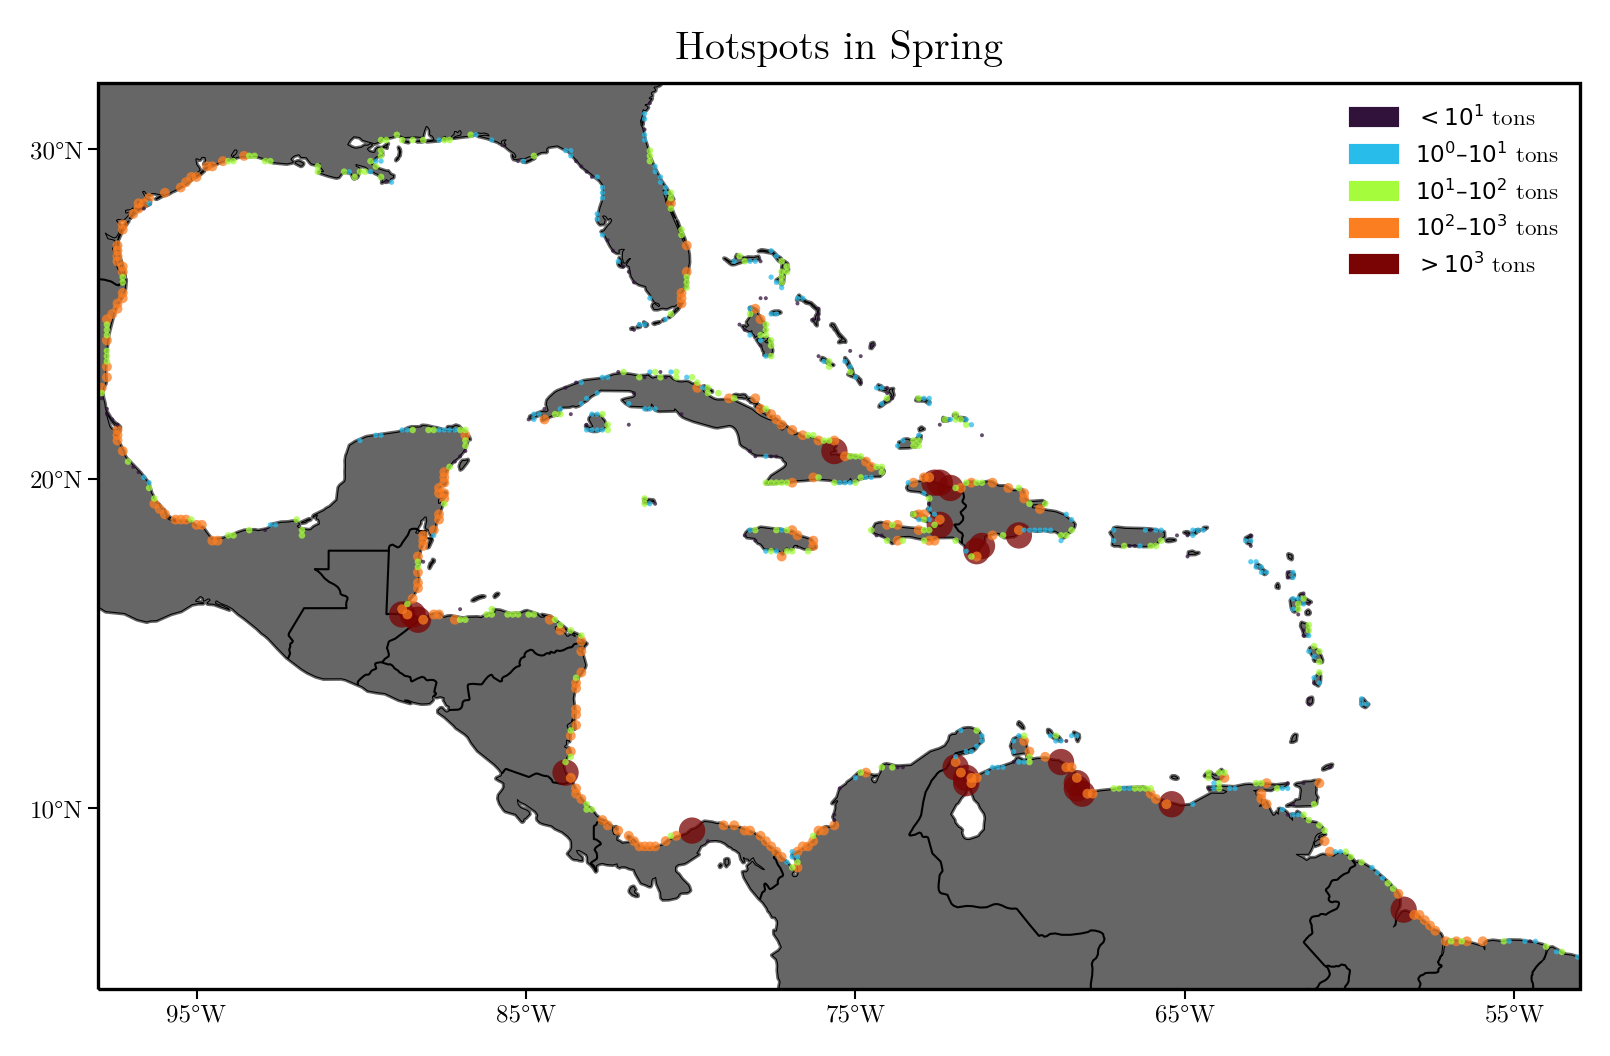

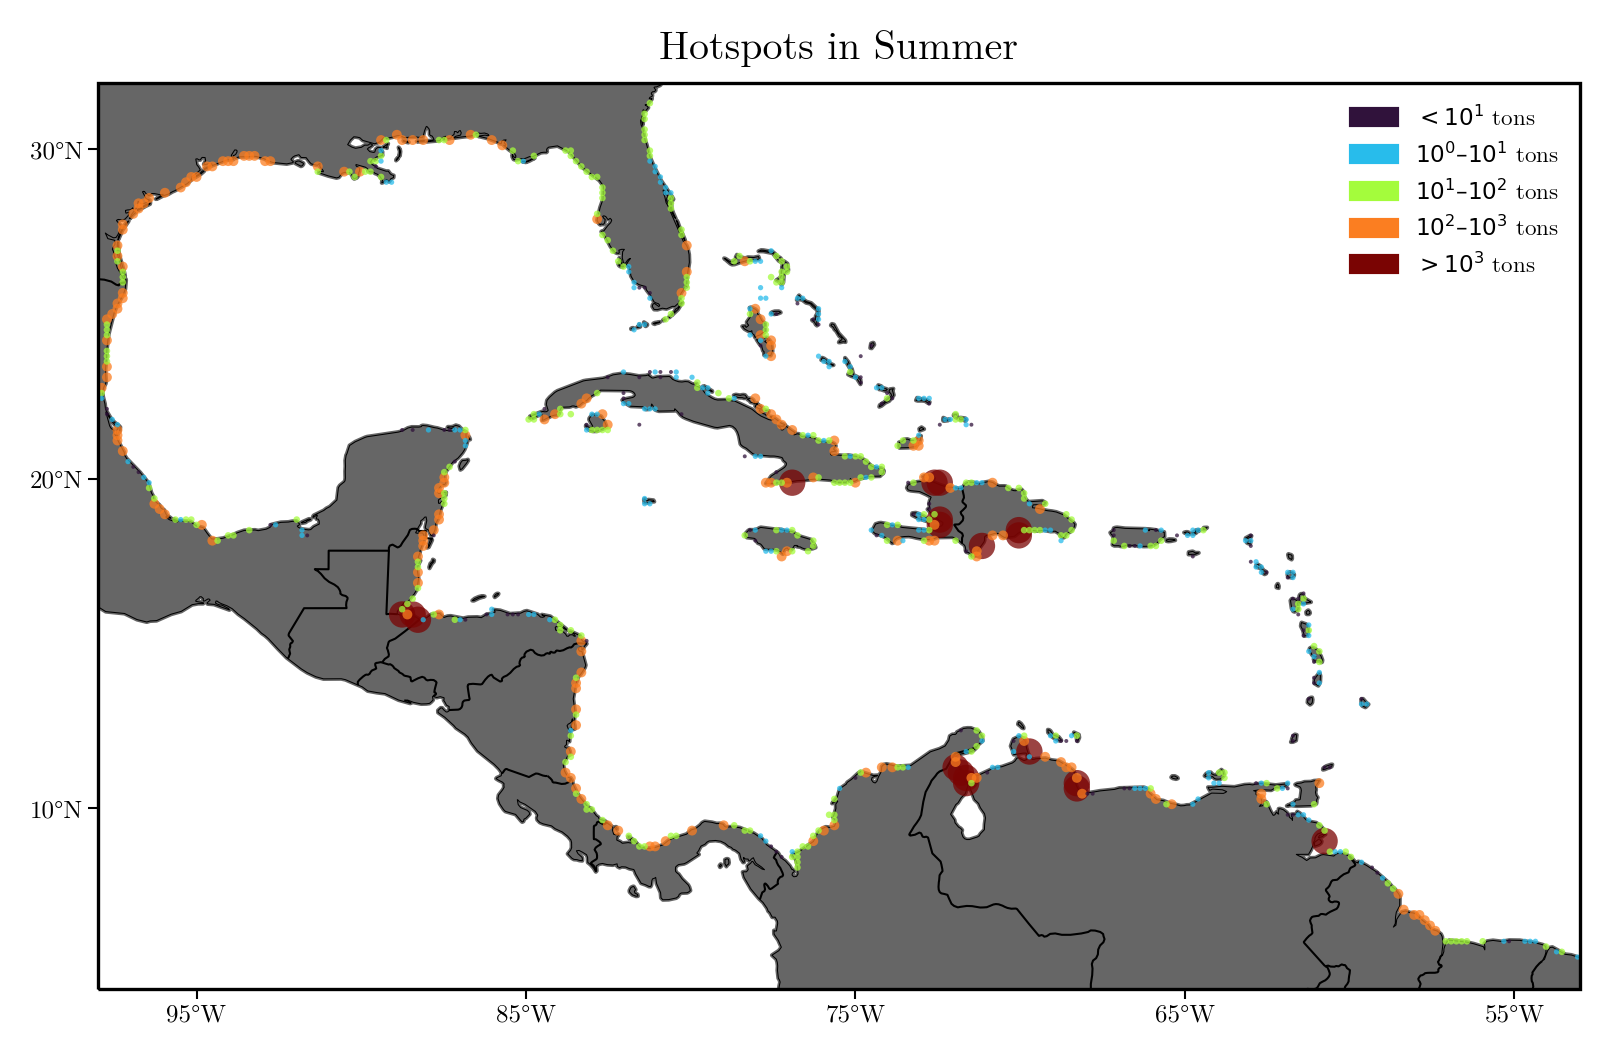

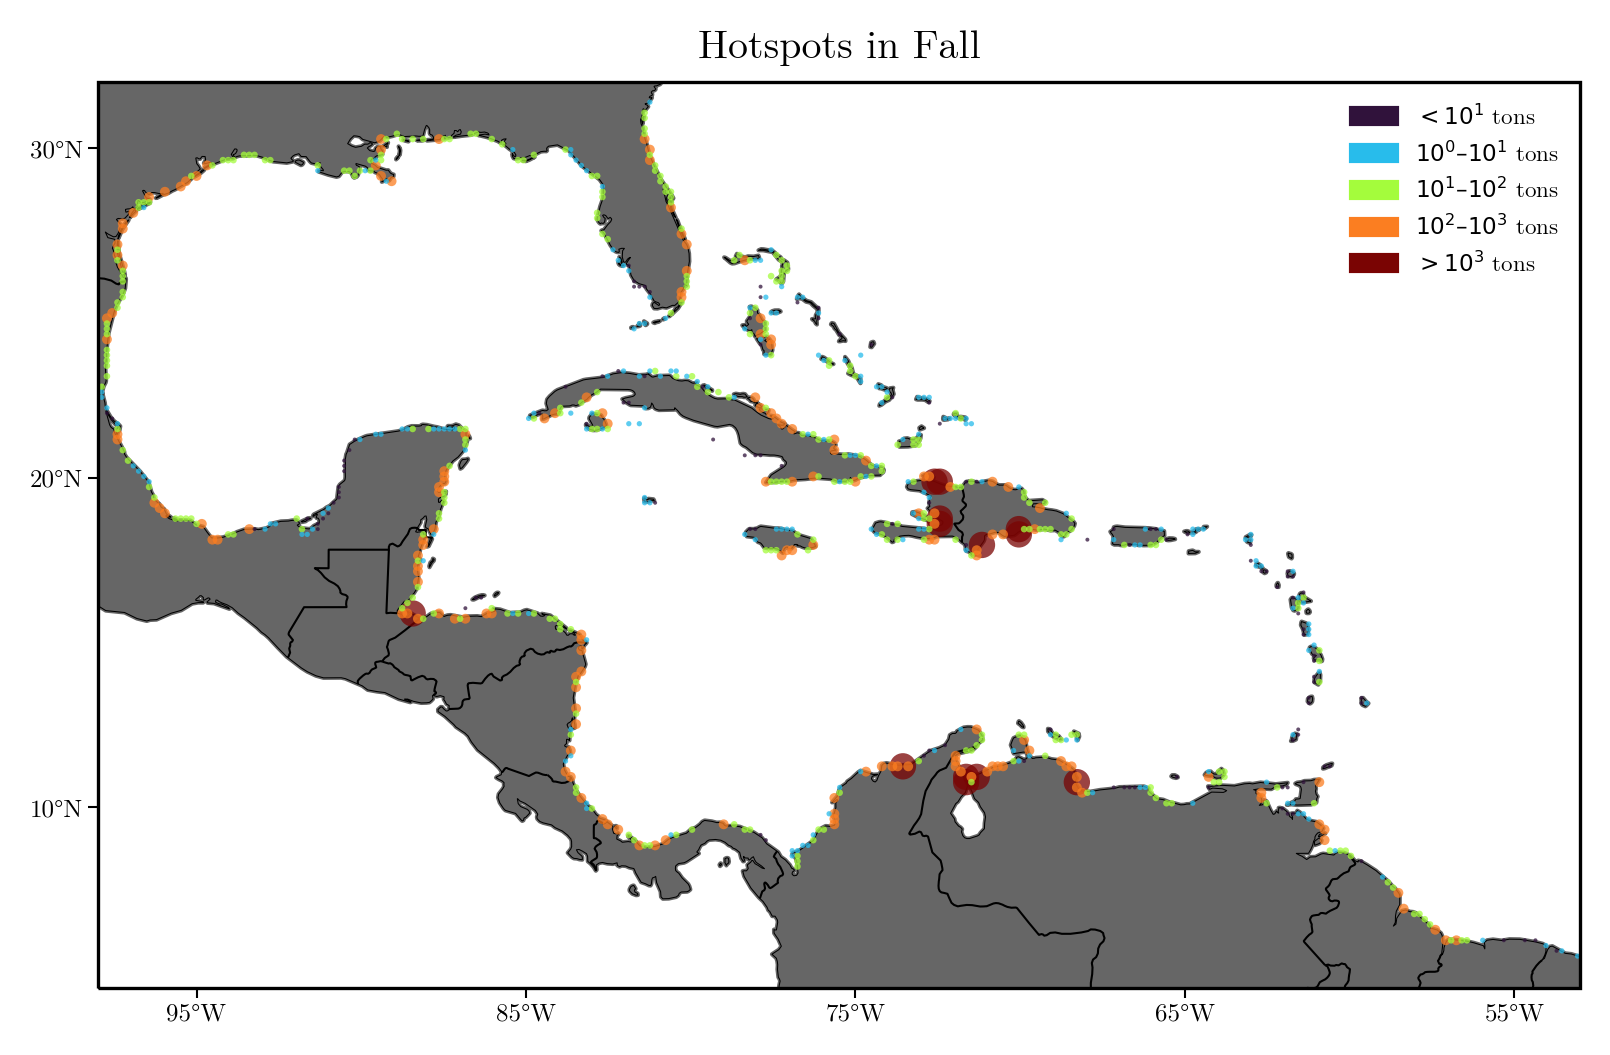

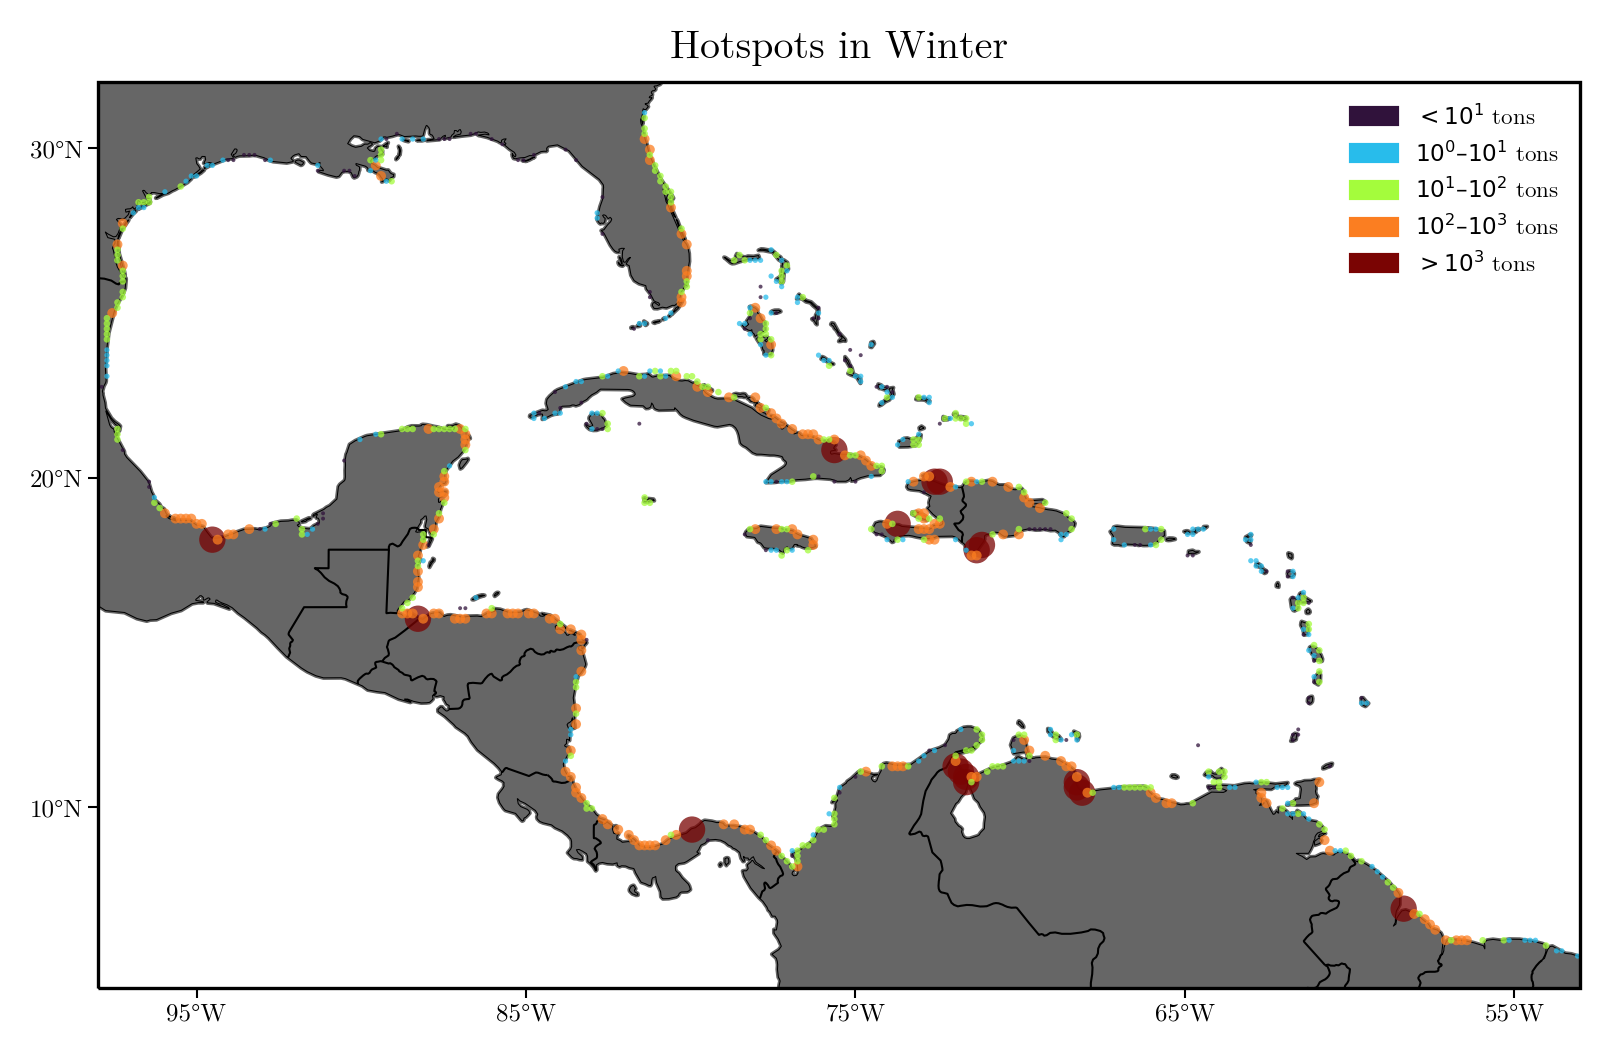

In [1097]:
for s in [0,1,2,3]:
    fig = plt.figure(dpi=300, figsize=(8,4))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(), aspect='equal')

    ax.add_feature(cfeature.LAND, facecolor='0.4', zorder=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, zorder=1)

    #a = ax.scatter(plon[nnz[1]], plat[nnz[0]], 
    #           s=np.exp(beached_mass[nnz]/(0.20*np.nanmax(beached_mass))), 
    #          c=beached_mass[nnz], lw=2, marker='o',
    #          )

    #nnz = np.where(beached_mass)
    #colors, scaled_mass = radius(beached_mass[nnz])
    nnz = np.where(coastal_beached_mass_seasons[s])
    colors, scaled_mass = radius_season(coastal_beached_mass_seasons[s][nnz])

    patches = []
    for x1, y1, r in sorted(zip(plon[nnz[1]], plat[nnz[0]], scaled_mass), key = lambda x: x[2], reverse=True):
        circle = Circle((x1, y1), r)
        #circle = Wedge((x1, y1), r, 0, 360, width=0.1)
        patches.append(circle)

    cmap = plt.cm.turbo

    p = PatchCollection(patches, alpha=0.75, cmap=cmap_name)
    p.set_array(sorted(colors, reverse=True))
    p.set_clim([np.min(colors), np.max(colors)])
    ax.add_collection(p)

    ax.set_xlim([-98, -53])
    ax.set_ylim([4.5, 32])
    ax.set_xticks([-95, -85,-75,-65,-55], crs=ccrs.PlateCarree())
    ax.set_yticks([10,20,30], crs=ccrs.PlateCarree())

    #ax.set_xlim([-86, -85])
    #ax.set_ylim([29, 31])

    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    
    ax.set_title(f"Hotspots in {seasons[s]}")

    #fig.colorbar(p)

    handles = []
    handles.append(Polygon([(0,0),(5,0)], color=cmap(p.norm(np.min(colors))), label=f'$<10^{1}$ tons'))
    for i,c in enumerate(np.unique(colors)[1:-1]):
        handles.append(Polygon([(0,0),(10,0),(0,-10)], color=cmap(p.norm(c)), label=f'$10^{i}–10^{i+1}$ tons'))
    handles.append(Polygon([(0,0),(10,0),(0,-10)], color=cmap(p.norm(np.max(colors))), label=f'$>10^{i+1}$ tons'))
    ax.legend(handles=handles, frameon=False, fontsize='x-small')  
    
    fig.savefig(f'hotspot_{seasons[s]}.png', bbox_inches='tight', format='png', dpi=600)